#Convolutional Neural Networks
In this lab, you will implement the most important operation of convolutional neural networks, i.e. the **convolution operation**. In addition to see how the operation works, you will implement a Pytorch layer and use it to create your own CNNs. To test those CNNs, you will work again with the CIFAR-10 image recognition dataset.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

##Convolution operation and layer
We will implement a 2D convolutional layer in Pytorch. For now, do not care about the efficiency of the implementation, i.e. do not think how to implement the convolution operation in a vectorized way. 

Remember that to implement a layer, you have to create a new class that inherits from `nn.Module`. There are two functions you have to think about:

`__init__` function:


*   Look carefully at the arguments given in its signature.
*   Create a tensor for the weights of the layer with the appropriate shape. The shape of our weights is determined by the arguments `in_channels`, `out_channels` and `filter_size`. We will follow the Pytorch standard and locate the channels first, i.e. (channels, height, width).
*   Initialize the weights using Kaiming uniform initialization, because we plan to use ReLU activations in our CNNs.
*   Create the bias tensor with the appropriate shape. The shape of our bias is determied by the argument `out_channels`.
*   Initialize the bias tensor to zeros.
*   Store the `stride` and `padding` arguments in class attributes (you will need both in the `forward` function).

`forward` function:


*   Calculate the output volume size and create a tensor of zeros with that shape.
*   Pad the input volume `x` as specified by the `padding` argument. Hint: have a look at `torch.nn.functional.pad` function. 
*   Implement nested `for` loops to convolve the filters along the image. Check carefully the dimensions of the input volume and the weights. Remember to apply the suitable stride. Hint: use tensor slicing to select the appropriate image region to be multiplied by the weights.

**EXERCISE:** Implement the layer `NaiveConv2d` following the instructions above.

In [2]:
from torch import nn

class NaiveConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, filter_size, stride, padding):
    super().__init__()
    self.w = torch.empty((out_channels, in_channels, filter_size, filter_size))
    #self.w = torch.empty(out_channels, in_channels, filter_size, filter_size) 
    torch.nn.init.kaiming_uniform_(self.w)
    self.b = torch.zeros((out_channels,))
    self.stride = stride
    self.padding = padding

    # Convert self.w (weights) and self.b (bias) into nn.Parameter for the training process
    self.w = nn.Parameter(self.w)
    self.b = nn.Parameter(self.b)

  def forward(self, x):
    out = None

    # Extract the most important dimension parameters
    N, C, H, W = x.shape # N = batch size; C = channels; H = height; W = width
    F, C, HH, WW = self.w.shape # F = #filters; C = channels, HH = filter height; WW = filter width

    # if "(N + 2 * pad - F)/s" does not yield an int, that means our pad/stride 
    # setting is wrong
    assert (H + 2 * self.padding - HH) % self.stride == 0, '[Sanity Check] [FAIL]: Conv Layer Failed in Height'
    assert (W + 2 * self.padding - WW) % self.stride == 0, '[Sanity Check] [FAIL]: Conv Layer Failed in Width'


    # output volume size    
    Hout = (H + 2 * self.padding - HH) // self.stride + 1 
    Wout = (W + 2 * self.padding - WW) // self.stride + 1

    # create output volume tensor after convolution (tensor of zeros)    
    out = torch.zeros((N, F, Hout, Wout))

    # pad H and W axes of the input data
    x_pad = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding), 'constant')

    # naive Loops
    for n in range(N): # for each neuron
        for f in range(F): # for each filter/kernel
            for i in range(0, Hout): # for each y activation
                for j in range(0, Wout): # for each x activation
                    # each neuron in a particular depth slide in the output volume
                    # shares weights over the same HH x WW x C region they're 
                    # looking at in the image; also one bias/filter                    
                    out[n, f, i, j] = (x_pad[n, :, i*self.stride:i*self.stride+HH, j*self.stride:j*self.stride+WW] * self.w[f, :, :, :]).sum() + self.b[f]
    

    return out

You can run the cell below to check whether the implementation of the conv layer is correct. Look carefully at the code below and see how we can set our own weights and biases for the conv layer, overwritting the initialization of the `__init__` function. 

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

# Convert to torch.Tensor
x = torch.Tensor(x)
w = torch.Tensor(w)
b = torch.Tensor(b)

# Create a conv layer and execute a forward pass with our hand-made filters
conv = NaiveConv2d(in_channels=3, out_channels=3, filter_size=4, stride=2, padding=1)
conv.w = nn.Parameter(w) # NOTE: we use previously defined w to substitute the "randomly" initialized weights
conv.b = nn.Parameter(b) # NOTE: we use previously defined b to substitute the zero-initialized biases
out = conv(x) # Forward pass

# If implemented correctly, the output should be this tensor
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-7
print('NaiveConv2d max abs error ', (out - correct_out).abs().max())

NaiveConv2d max abs error  tensor(1.1921e-07, grad_fn=<MaxBackward1>)


Now that we have a functional conv layer, to both check your implementation further and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations:
  

*   Grayscale conversion: we will use a hand-designed filter to convert a RGB image to grayscale.
*   Edge detection: we will use another hand-designed filter to detect horizontal edges in the blue channel.

The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

First of all, we will download two images:

In [4]:
!wget --output-document=puppy.jpg https://upload.wikimedia.org/wikipedia/commons/c/c0/Fm_shiba_inu_puppy.jpg
!wget --output-document=kitten.jpg https://i0.wp.com/jmcolberg.com/weblog/archives/kitten.jpg

--2022-11-26 16:14:15--  https://upload.wikimedia.org/wikipedia/commons/c/c0/Fm_shiba_inu_puppy.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28957 (28K) [image/jpeg]
Saving to: ‘puppy.jpg’

puppy.jpg           100%[===================>]  28.28K  --.-KB/s    in 0.01s   

2022-11-26 16:14:15 (1.88 MB/s) - ‘puppy.jpg’ saved [28957/28957]

--2022-11-26 16:14:15--  https://i0.wp.com/jmcolberg.com/weblog/archives/kitten.jpg
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22734 (22K) [image/jpeg]
Saving to: ‘kitten.jpg’

kitten.jpg          100%[===================>]  22.20K  --.-KB/s    in 0.02s   

2022-11-26 16:14:15 (913 KB/s) - ‘kitten.jpg’ saved [22734/22734]



The images `puppy.jpg` and `kitten.jpg` are in our disk (you can check in the left menu-bar with the Files option). We will read both images and display them:

<class 'imageio.core.util.Array'>


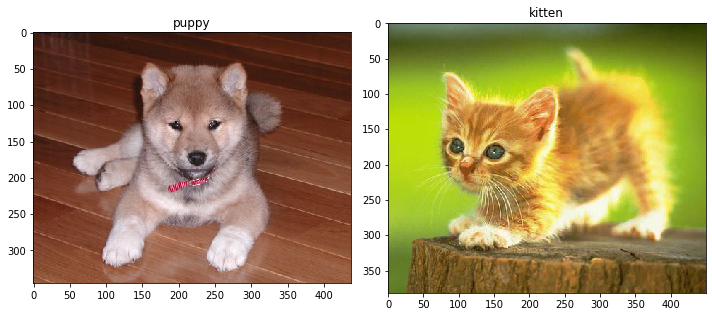

In [5]:
from imageio import imread
from PIL import Image

kitten = imread('kitten.jpg')
puppy = imread('puppy.jpg')
print(type(puppy))

plt.subplot(1, 2, 1)
plt.imshow(puppy)
plt.title('puppy')

plt.subplot(1, 2, 2)
plt.imshow(kitten)
plt.title('kitten')

plt.tight_layout()
plt.show()

As can be seen, none of the images is square (they are wider than taller). In the cell below, we will extract a square crop of both images and we will define two filters of shape (3, 3) for grayscale conversion and horizontal edge detection (in the blue channel). Read carefully the code and comments.

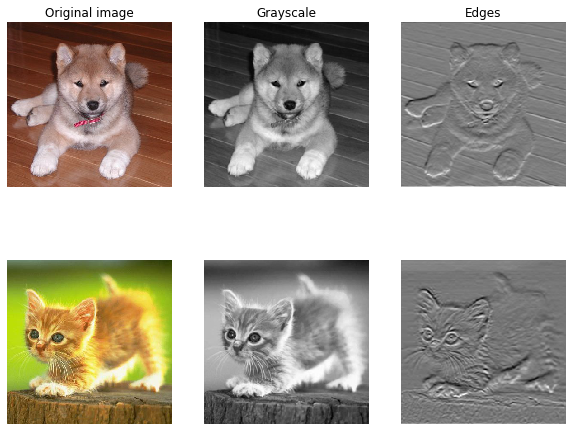

In [6]:
# kitten and puppy are not squeare
d = puppy.shape[1] - puppy.shape[0]
puppy_cropped = puppy[:, d//2:-d//2, :]

d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy_cropped).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))

# Prepare the input volume for our conv layer
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1)) # Remember, in Pytorch, channel first
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Convert x, w and b to tensors
x = torch.Tensor(x)
w = torch.Tensor(w)
b = torch.Tensor(b)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
conv = NaiveConv2d(in_channels=3, out_channels=2, filter_size=3, stride=1, padding=1)
conv.w = nn.Parameter(w)
conv.b = nn.Parameter(b)
out = conv(x)

# Code to visualize the obtained results
def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy_cropped, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0].detach().numpy())
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1].detach().numpy())
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0].detach().numpy())
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1].detach().numpy())
plt.show()

There you are! The results are quite nice, aren't they? This is an example of what convolution operations can do. But as we saw in the theoretical sessions, designing filters manually is not a very good idea. We should **learn those filters from data!** However, our implementation of the conv layer is quite slow and it will prevent us from running meaningful training processes. That is why we have to turn to a vectorized implementation of the convolution operation.

###Fast convolutions
Implementing a fast version of the convolution operation, i.e. a vectorized version, is not trivial at all. For that reason, we will provide our own implementation. But before looking at the solution itself, let's try to understand the building blocks with some illustrative examples.

The key concept for the vectorization is to get rid off those 4 for loops of our `NaiveConv2d` forward pass. For that purpose, Pytorch has the `tensor.unfold()` function, which can generate the desired patches or image regions for us. See the following example:

In [7]:
# Batch size = 2, Channels = 3, Height = 4, Width = 4
B, C, H, W = 2, 3, 4, 4
# Generate an artificial image
x = torch.arange(B*C*H*W).view(B, C, H, W)
print('Example image:')
print(x)

Example image:
tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]],

         [[16, 17, 18, 19],
          [20, 21, 22, 23],
          [24, 25, 26, 27],
          [28, 29, 30, 31]],

         [[32, 33, 34, 35],
          [36, 37, 38, 39],
          [40, 41, 42, 43],
          [44, 45, 46, 47]]],


        [[[48, 49, 50, 51],
          [52, 53, 54, 55],
          [56, 57, 58, 59],
          [60, 61, 62, 63]],

         [[64, 65, 66, 67],
          [68, 69, 70, 71],
          [72, 73, 74, 75],
          [76, 77, 78, 79]],

         [[80, 81, 82, 83],
          [84, 85, 86, 87],
          [88, 89, 90, 91],
          [92, 93, 94, 95]]]])


In [8]:
filter_h, filter_w = 2, 2 # a 2x2 filter size
stride = 2

# First unfold dimension 2 (height) and afterwards dimension 3 (width)
patches = x.unfold(2, filter_h, stride).unfold(3, filter_w, stride)
print('Created patches:')
print(patches)

Created patches:
tensor([[[[[[ 0,  1],
            [ 4,  5]],

           [[ 2,  3],
            [ 6,  7]]],


          [[[ 8,  9],
            [12, 13]],

           [[10, 11],
            [14, 15]]]],



         [[[[16, 17],
            [20, 21]],

           [[18, 19],
            [22, 23]]],


          [[[24, 25],
            [28, 29]],

           [[26, 27],
            [30, 31]]]],



         [[[[32, 33],
            [36, 37]],

           [[34, 35],
            [38, 39]]],


          [[[40, 41],
            [44, 45]],

           [[42, 43],
            [46, 47]]]]],




        [[[[[48, 49],
            [52, 53]],

           [[50, 51],
            [54, 55]]],


          [[[56, 57],
            [60, 61]],

           [[58, 59],
            [62, 63]]]],



         [[[[64, 65],
            [68, 69]],

           [[66, 67],
            [70, 71]]],


          [[[72, 73],
            [76, 77]],

           [[74, 75],
            [78, 79]]]],



         [[[[80, 81],
         

Those patches are ready to be multiplied by our weight tensors or filters. Using tensor element-wise multiplications and sums, you can implement the convolution operation in a vectorized way. But even with those patches, the operation is far from simple. You have to transform and reshape the patches so they can be effectively multiplied by the weights, taking into account the shape of our weights. 

If you feel confident and strong, you can try to implement the vectorized convolution yourself using the `tensor.unfold()` function. We insist, **it is difficult**. That is why you can directly go to our solution below. Look at the code carefully and read the comments to try to understand what the code does and why. This example is probably one of the most difficult implementations you will see during this course. 

In [9]:
from torch import nn

class FastConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, filter_size, stride, padding):
    super().__init__()    
    self.w = torch.empty(out_channels, in_channels, filter_size, filter_size)    
    nn.init.kaiming_uniform_(self.w)
    self.b = torch.zeros(out_channels,)
    self.stride = stride
    self.padding = padding  

    # Convert self.w and self.b into nn.Parameter for the training process
    self.w = nn.Parameter(self.w)
    self.b = nn.Parameter(self.b)

  def forward(self, x):
    out = None

    # Extract the most important dimension parameters
    N, C, H, W = x.shape    
    F, C, HH, WW = self.w.shape    

    # if "(N + 2 * pad - F)/s" does not yield an int, that means our pad/stride 
    # setting is wrong
    assert (H + 2 * self.padding - HH) % self.stride == 0, '[Sanity Check] [FAIL]: Conv Layer Failed in Height'
    assert (W + 2 * self.padding - WW) % self.stride == 0, '[Sanity Check] [FAIL]: Conv Layer Failed in Width'    

    kh, kw = HH, WW # kernel or filter size. NOTE: the term 'kernel' is widely used as a synonym of filter
    dh, dw = self.stride, self.stride # stride 

    # pad H and W axes of the input data
    x_pad = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding), 'constant')   
    
    patches = None
    patches = x_pad.unfold(2, kh, dh).unfold(3, kw, dw) # N, C, h_windows, w_windows, kh, kw    

    patches = patches.contiguous().view(N, C, -1, kh, kw) # N, C, windows, kh, kw     
    # NOTE: With this operation we put all kh x kw patches of a channel in a row

    nb_windows = patches.size(2)

    # Now we have to shift the windows into the batch dimension.    
    patches = patches.permute(0, 2, 1, 3, 4) # N, nb_windows, C, kh, kw        
    
    # Calculate the conv operation manually    
    out = (patches.unsqueeze(2) * self.w.unsqueeze(0).unsqueeze(1)).sum([3, 4, 5]) + self.b
    
    out = out.permute(0, 2, 1) # batch_size, out_channels, output_pixels
    # assuming h = w
    h = w = int(out.size(2)**0.5)
    out = out.view(N, -1, h, w)

    return out

If there is something weird in the code, do not hesitate on asking us. 

In the next cell, we will check the performance of our two conv layers: `NaiveConv2d` and `FastConv2d`. To have a valid reference, we will use the Pytorch official implementation of the convolution operation: `nn.Conv2d`. We will compare the execution times of their forward passes and we will see whether their outputs match: 

In [10]:
import time

batch_size = 6
channels = 3
height, width = 32, 32
filters = 6
f = 5
stride = 1
padding = 0

x = torch.randn((batch_size, channels, height, width))

refconv = nn.Conv2d(in_channels=channels, out_channels=filters, kernel_size=f, padding=padding)
w = refconv.weight # Retrieve weights from the layer
b = refconv.bias # Retrieve bias from the layer

start = time.time()
refout = refconv(x)
end = time.time()
print(f'Time for reference Conv2d forward pass: {end - start}')
print(f'refout shape: {refout.shape}')
print('------------------------\n')

# FastConv2d
fconv = FastConv2d(in_channels=channels, out_channels=filters, filter_size=f, stride=stride, padding=padding)
fconv.w = w # Use the weights generated by reference Conv2d
fconv.b = b # Use the bias generated by reference Conv2d

start = time.time()
fout = fconv(x)
end = time.time()
print(f'Time for FastConv2d forward pass: {end - start}')
print(f'refout shape: {fout.shape}')
print('------------------------\n')

# NaiveConv2d
nconv = NaiveConv2d(in_channels=channels, out_channels=filters, filter_size=f, stride=stride, padding=padding)
nconv.w = w # Use the weights generated by reference Conv2d
nconv.b = b # Use the bias generated by reference Conv2d

start = time.time()
nout = nconv(x)
end = time.time()
print(f'Time for NaiveConv2d forward pass: {end - start}')
print(f'nout shape: {nout.shape}')
print('------------------------\n')

# Compare Naive and Fast output to reference Conv2d
print('FastConv2d max abs error ', (fout - refout).abs().max())
print('NaiveConv2d max abs error ', (nout - refout).abs().max())

Time for reference Conv2d forward pass: 0.07773041725158691
refout shape: torch.Size([6, 6, 28, 28])
------------------------

Time for FastConv2d forward pass: 0.008626461029052734
refout shape: torch.Size([6, 6, 28, 28])
------------------------

Time for NaiveConv2d forward pass: 1.3009135723114014
nout shape: torch.Size([6, 6, 28, 28])
------------------------

FastConv2d max abs error  tensor(7.1526e-07, grad_fn=<MaxBackward1>)
NaiveConv2d max abs error  tensor(7.1526e-07, grad_fn=<MaxBackward1>)


Execute the cell above more than once, since the first results are not conclusive. Several highlights from the results above:


*   The official `nn.Conv2d` layer is faster than our `FastConv2d` layer, which is faster than the `NaiveConv2d` layer. The difference between our two layers was expected, but what about the official implementation's performance? It turns out that `nn.Conv2d` is not implemented in Python, but in C and pure CUDA programming language. It is not possible to match its performance from a Python implementation.
*   Depending on the execution, the `FastConv2d` forward pass is more than 100 times faster than the `NaiveConv2d` version. That is a huge improvement!
*   Regarding the shape of the generated output volume, all three layers perfectly match. You can play with the input volume to see whether everything keeps consistent. Be careful, though: if you increase too much the input volume, `NaiveConv2d` may need too much time, and it can even crash the Colab runtime!
*   The max absolute error of our two layers compared with the official implementation is very low (around 1e-7). So our implementations seem to be correct.



## A CNN for image recognition
As we have our own fast and reliable conv layer, we will implement a full convolutional neural network (CNN) to recognise images. Our dataset, once again, will be the CIFAR-10 dataset.

###Prepare the dataset
The following steps should already be familiar to you. We download the CIFAR-10 training dataset from `torchvision.datasets` and prepare it for our training process. For that purpose, we create train and dev splits and visualize some images to check everything is fine.

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

print(f'Dataset samples: {len(training_data)}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Dataset samples: 50000


In [12]:
# Split the indices in a stratified way
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.arange(len(training_data))
train_indices, dev_indices = train_test_split(indices, train_size=40000, stratify=training_data.targets, random_state=42)

train_set = Subset(training_data, train_indices)
dev_set = Subset(training_data, dev_indices)

print(f'Train samples: {len(train_set)}')
print(f'Dev samples: {len(dev_set)}')

Train samples: 40000
Dev samples: 10000


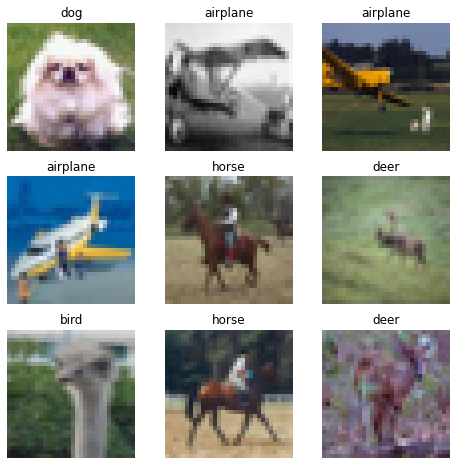

In [13]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0)) # Permute since Pytorch uses (C, H, W) and plt needs (H, W, C)
plt.show()

###Implement the CNN
Using our `FastConv2d` layer, you have to implement now a convolutional neural network. The architecture is as follows:


*   Conv layer of 6 filters, size 5x5, stride 1 and padding 0.
*   ReLU activation function.
*   Max pooling of size 2x2 and stride 2.
*   Conv layer of 16 filters, size 5x5, stride 1 and padding 0.
*   ReLU activation function.
*   Max pooling of size 2x2 and stride 2.
*   Fully connected layer of 120 neurons.
*   ReLU activation function.
*   Fully connected layer of 84 neurons.
*   ReLU activation function.
*   Fully connected layer of 10 neurons.

**EXERCISE:** Implement a CNN with the specified architecture, based on our `FastConv2d` layer.

In [14]:
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(0)

class MyCNN(nn.Module):
    def __init__(self):
      super(MyCNN, self).__init__()
   
      self.conv1 = FastConv2d(3,6,5,1,0)
      self.conv2 = FastConv2d(6,16,5,1,0)
      self.l1 = nn.Linear(400,120)
      self.l2 = nn.Linear(120,84)
      self.l3 = nn.Linear(84,10)
      self.relu = nn.ReLU()
      self.pool = nn.MaxPool2d(2,2)
      self.flatten = nn.Flatten()    


    def forward(self, x):
   
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.flatten(x)
      x = self.l1(x)
      x = self.relu(x)
      x = self.l2(x)
      x = self.relu(x)
      x = self.l3(x)

      return x

model = MyCNN()
print(model)

MyCNN(
  (conv1): FastConv2d()
  (conv2): FastConv2d()
  (l1): Linear(in_features=400, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=84, bias=True)
  (l3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


Now, we will create the `device` string and store there the fastest available device, either 'cpu' or 'cuda'. As always, we recommend to use Colab GPUs.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


We define our usual `train_loop` and `test_loop` functions, as in the previous lab:

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, device):        
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
        
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Store loss and accuracy
      train_loss += loss.item()
      train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    test_acc /= size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc

And finally, we implement the training and evaluation process. Our objective now is to check whether our CNN learns something, so we will not run many epochs. 

In [17]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 2

# For reproducibility
torch.manual_seed(0)

model = MyCNN()
model = model.to(device)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.304759  [    0/40000]
loss: 1.905145  [ 6400/40000]
loss: 1.728630  [12800/40000]
loss: 1.835215  [19200/40000]
loss: 1.546178  [25600/40000]
loss: 1.440232  [32000/40000]
loss: 1.562891  [38400/40000]
train loss: 1.7089735641479493, train_acc: 0.374
Test Error: 
 Accuracy: 45.3%, Avg loss: 1.499784 

Epoch 2
-------------------------------
loss: 1.600967  [    0/40000]
loss: 1.427778  [ 6400/40000]
loss: 1.411426  [12800/40000]
loss: 1.118949  [19200/40000]
loss: 1.221458  [25600/40000]
loss: 1.266093  [32000/40000]
loss: 1.514403  [38400/40000]
train loss: 1.4226872903823853, train_acc: 0.48145
Test Error: 
 Accuracy: 51.1%, Avg loss: 1.357642 

Done!
Best dev accuracy: 0.5115 in epoch 2
Training time: 21.318247318267822


We obtain 0.47 train accuracy and 0.50 dev accuracy. Let's implement the same network, but using the official `nn.Conv2d` layer instead of ours, to have a comparison.

**EXERCISE:** Implement the same CNN architecture as `MyCNN`, but using `nn.Conv2d` layers instead of our `FastConv2d` layers. 

In [18]:
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(0)

class OfficialCNN(nn.Module):
    def __init__(self):
      super(OfficialCNN, self).__init__()
     
      self.conv1 = nn.Conv2d(3,6,5,1,0)
      self.conv2 = nn.Conv2d(6,16,5,1,0)
      self.l1 = nn.Linear(400,120)
      self.l2 = nn.Linear(120,84)
      self.l3 = nn.Linear(84,10)
      self.relu = nn.ReLU()
      self.pool = nn.MaxPool2d(2,2)
      self.flatten = nn.Flatten() 


    def forward(self, x):
  
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.flatten(x)
      x = self.l1(x)
      x = self.relu(x)
      x = self.l2(x)
      x = self.relu(x)
      x = self.l3(x)

      return x


In [19]:
import time

learning_rate = 1e-3
batch_size = 64
epochs = 2

# For reproducibility
torch.manual_seed(0)

#Instantiate a OfficialCNN object in the model variable
model = OfficialCNN()
model = model.to(device)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.306402  [    0/40000]
loss: 2.195158  [ 6400/40000]
loss: 1.971110  [12800/40000]
loss: 1.881469  [19200/40000]
loss: 1.616457  [25600/40000]
loss: 1.872215  [32000/40000]
loss: 1.598581  [38400/40000]
train loss: 1.8334749683380127, train_acc: 0.3234
Test Error: 
 Accuracy: 42.1%, Avg loss: 1.614777 

Epoch 2
-------------------------------
loss: 1.733162  [    0/40000]
loss: 1.619028  [ 6400/40000]
loss: 1.699101  [12800/40000]
loss: 1.557911  [19200/40000]
loss: 1.652556  [25600/40000]
loss: 1.572012  [32000/40000]
loss: 1.362606  [38400/40000]
train loss: 1.5023770135879517, train_acc: 0.45145
Test Error: 
 Accuracy: 47.4%, Avg loss: 1.438734 

Done!
Best dev accuracy: 0.4742 in epoch 2
Training time: 19.940650463104248


With this implementation, we get a train accuracy of 0.45 and dev accuracy around 0.47. This is 2.5 points below our own implementation. Can you explain why?

**HINT:** Have a look at the `nn.Conv2d` documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Is there anything different?

The architecture we used above was OK to check that our layer is working well, but it is still too simple for this task. Let's try with a deeper CNN. More concretely, inspired on the VGG architecture, implement the following CNN:


*   2 x Conv layers of 32 filters of size 3x3 (stride 1 and padding = 'same') followed by ReLU activations.
*   Max pooling of size 2x2 and stride 2.
*   2 x Conv layer of 64 filters of size 3x3 (stride 1 and padding = 'same') followed by ReLU activations.
*   Max pooling of size 2x2 and stride 2.
*   2 x Conv layer of 128 filters of size 3x3 (stride 1 and padding = 'same') followed by ReLU activations.
*   Max pooling of size 2x2 and stride 2.
*   Fully connected layer of 128 neurons followed by ReLU activation.
*   Fully connected layer of 10 neurons (number of classes).

A couple of details:


*   Pytorch and other deep learning frameworks, offer the option to make the conv layer calculate the needed padding to keep the input height and width unaltered in the output. For that, we have to specify `padding = 'same'`.
*   `nn.Conv2d` layer and `nn.Linear` layer use their own weight and bias initialization. For this network, initialize the weights of all the layers using Kaiming uniform initialization (do not change bias initialization).

**EXERCISE:** Implement the CNN architecture defined above. This time, use the official `nn.Conv2d` layer to train faster. Remember to reinitialize the weights of all the layers.






In [21]:
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(0)

class DeepCNN(nn.Module):
    def __init__(self):
      super(DeepCNN, self).__init__()

      self.conv1 = nn.Conv2d(3,32,3,1,padding = 'same')
      self.conv2 = nn.Conv2d(32,32,3,1,padding = 'same')
      self.conv3 = nn.Conv2d(32,64,3,1,padding = 'same')
      self.conv4 = nn.Conv2d(64,64,3,1,padding = 'same')
      self.conv5 = nn.Conv2d(64,128,3,1,padding = 'same')
      self.conv6 = nn.Conv2d(128,128,3,1,padding = 'same')
      self.l1 = nn.Linear(2048,128)
      self.l2 = nn.Linear(128,10)
      self.relu = nn.ReLU()
      self.pool = nn.MaxPool2d(2,2)
      self.flatten = nn.Flatten() 


    def forward(self, x):
 
      x = self.conv1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv3(x)
      x = self.relu(x)
      x = self.conv4(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.conv5(x)
      x = self.relu(x)
      x = self.conv6(x)
      x = self.relu(x)
      x = self.pool(x)
      x = self.flatten(x)
      x = self.l1(x)
      x = self.relu(x)
      x = self.l2(x)

      return x


Let's train and evaluate our new VGG-inspired deep CNN for CIFAR-10. We will use a mini-batch size of 128 to speed-up the training process of only 10 epochs. 

In [22]:
import time

learning_rate = 1e-3
batch_size = 128
epochs = 10

# For reproducibility
torch.manual_seed(0)

model = DeepCNN()
model = model.to(device)

# create train and dev dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.303713  [    0/40000]
loss: 1.776458  [12800/40000]
loss: 1.592947  [25600/40000]
loss: 1.604837  [38400/40000]
train loss: 1.801474221598226, train_acc: 0.330575
Test Error: 
 Accuracy: 43.9%, Avg loss: 1.539271 

Epoch 2
-------------------------------
loss: 1.497806  [    0/40000]
loss: 1.357496  [12800/40000]
loss: 1.233930  [25600/40000]
loss: 1.099327  [38400/40000]
train loss: 1.3572989039527723, train_acc: 0.5039
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.235081 

Epoch 3
-------------------------------
loss: 1.388038  [    0/40000]
loss: 1.019051  [12800/40000]
loss: 1.230351  [25600/40000]
loss: 1.089857  [38400/40000]
train loss: 1.144517499798784, train_acc: 0.5867
Test Error: 
 Accuracy: 62.4%, Avg loss: 1.060144 

Epoch 4
-------------------------------
loss: 0.821477  [    0/40000]
loss: 1.044811  [12800/40000]
loss: 0.945378  [25600/40000]
loss: 1.219502  [38400/40000]
train loss: 0.9957086491508605, train_acc: 0.646325
Te

**Best development accuracy of 0.75!** Do you remember the best development accuracy of lab 3.2? It was around 0.57. For that lab, we used learning rate schedulers, data augmentation and weight decay for a training process of almost 150 epochs. As can be seen, the difference is very important. 



But there is another interesting parameter to look at. Even though our deep CNN has 6 conv layers and 2 FC layers for a total of 8 layers, the total number of trainable parameters is not that high:

In [23]:
# Print the total number of trainable parameters of DeepCNN model
sum(p.numel() for p in model.parameters() if p.requires_grad)

550570

To put it in context: while our `DeepCNN` has ~550K parameters, the MLP we used for lab 3.2 had around 1.8M parameters! Now our results are even more interesting: with a network which is ~3.5 times smaller in terms of parameters (and thus, lower capacity) and a much simpler training procedure, we obtain 18 points more for dev accuracy. This is a very good example of how important are neural network architectures. 

##Transfer learning
You will use a ResNet-18 pretrained in Imagenet to check how two different transfer learning approaches work for our image recognition problem. First of all, let's import the needed libraries and set our processing device:

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


###Fine-tuning a frozen CNN
The first transfer learning approach consists on using a pretrained CNN (a ResNet-18 in our case), get rid off its last FC layer and put a new one with the number of classes of our dataset (10). We will freeze all the parameters of the CNN and only train the last FC layer. 

**EXERCISE:** Check the web and find how you can download a ResNet-18 model pretrained in Imagenet. Afterwards, freeze all the parameters of the model and substitute the last FC layer with a new one, specific to our task.

In [26]:

# Download the pretrained resnet18 model from torchvision and store it in the model_frozen variable
model_frozen = torchvision.models.resnet18()


# Freeze all the parameters of the model (Hint: parameters have a boolean attribute requires_grad)
for param in model_frozen.parameters():
  param.requires_grad = False


# Substitute the last FC layer of the ResNet with a new one
# Hint: parameters of newly constructed modules have requires_grad=True by default
model_frozen.fc = nn.Linear(512,10)

model_frozen = model_frozen.to(device)

In [27]:
model_frozen

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Print the total number of trainable parameters of the model
sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)

5130

As we are using a ResNet-18, we have to preprocess images the same way the network did in its training process. Specifically, ResNet-18 normalizes the input using the mean and standard deviation of the Imagenet training set.

**EXERCISE:** Write the appropriate transforms for the `train_set` and `dev_set` we created before. Check the web to find out the mean and standard deviation required by ResNet-18.

In [29]:
# Create our_transforms
our_transforms = torchvision.transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize(size=([256]), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Add the transforms to our dataset
# NOTE: From now on, train_set and dev_set will always have these transforms
train_set.dataset.transform = our_transforms 
dev_set.dataset.transform = our_transforms 

Everything is ready to train our new network. We will use the usual training code. Check the hyperparameters and the obtained results.

In [30]:
import time

learning_rate = 1e-3
batch_size = 128
epochs = 10

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_frozen.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_frozen, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_frozen, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.521290  [    0/40000]
loss: 2.019274  [12800/40000]
loss: 2.011737  [25600/40000]
loss: 2.017157  [38400/40000]
train loss: 2.0847538351631774, train_acc: 0.237925
Test Error: 
 Accuracy: 28.8%, Avg loss: 1.983374 

Epoch 2
-------------------------------
loss: 1.982820  [    0/40000]
loss: 2.021900  [12800/40000]
loss: 1.832161  [25600/40000]
loss: 1.956386  [38400/40000]
train loss: 1.944265352651334, train_acc: 0.2956
Test Error: 
 Accuracy: 31.6%, Avg loss: 1.898365 

Epoch 3
-------------------------------
loss: 1.944718  [    0/40000]
loss: 1.831253  [12800/40000]
loss: 1.969881  [25600/40000]
loss: 1.851946  [38400/40000]
train loss: 1.8848034010146753, train_acc: 0.3227
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.876271 

Epoch 4
-------------------------------
loss: 1.889812  [    0/40000]
loss: 1.860601  [12800/40000]
loss: 1.904979  [25600/40000]
loss: 1.839758  [38400/40000]
train loss: 1.8504517268829834, train_acc: 0.335975
T

Well, the results are not very good. The accuracy obtained in development (0.46) is far from our previous 0.75. What is going on here? Can you explain it? Think about it a couple of minutes before continuing with the lab.

###Fine-tuning the complete CNN
The problem with the previous approach was that Imagenet and CIFAR-10 are very different datasets. The pretrained network was trained on images of size 224x224x3, whereas CIFAR-10 has images of size 32x32x3. The filters learned on Imagenet images do not transfer well to CIFAR-10, as they are. Besides, we were trying to learn just a linear layer of 10 neurons on top of the features extracted by the frozen ResNet-18. Too narrow approach given the dissimilarities of both datasets.

So let's try another transfer learning approach: we will fine-tune the complete ResNet-18 pretrained on Imagenet.

**EXERCISE:** Download a pretrained ResNet-18 and substitute its final FC layer by a new one with 10 neurons.

In [31]:
model_ft = torchvision.models.resnet18()
model_ft.fc = nn.Linear(512,10)

model_ft = model_ft.to(device)

In principle, our datasets are already prepared for a ResNet-18 from the previous exercises, so we can proceed to train the network. Check carefully the hyperparameters we use:

In [32]:
import time

learning_rate = 1e-3
batch_size = 128
epochs = 10

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_ft, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_ft, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 2.382629  [    0/40000]
loss: 1.540665  [12800/40000]
loss: 1.272897  [25600/40000]
loss: 1.108021  [38400/40000]
train loss: 1.4598889453723407, train_acc: 0.46325
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.183046 

Epoch 2
-------------------------------
loss: 1.120554  [    0/40000]
loss: 1.065938  [12800/40000]
loss: 0.848901  [25600/40000]
loss: 0.843825  [38400/40000]
train loss: 0.9215874266319762, train_acc: 0.6721
Test Error: 
 Accuracy: 67.1%, Avg loss: 0.942144 

Epoch 3
-------------------------------
loss: 0.761688  [    0/40000]
loss: 0.703955  [12800/40000]
loss: 0.747832  [25600/40000]
loss: 0.727902  [38400/40000]
train loss: 0.6862234070468635, train_acc: 0.76075
Test Error: 
 Accuracy: 66.6%, Avg loss: 1.030083 

Epoch 4
-------------------------------
loss: 0.717693  [    0/40000]
loss: 0.805636  [12800/40000]
loss: 0.492936  [25600/40000]
loss: 0.558013  [38400/40000]
train loss: 0.5545081201071937, train_acc: 0.807525


This is much better! We get **0.80 dev accuracy** without too much effort. Think about what we did here: we used a ResNet-18 network pretrained in Imagenet. The weights learned in Imagenet served as a initialization for our problem, i.e. we did not use "randomly" initialized weights, but weights that were useful in another image recognition task. However, instead of relying on those weights, we optimized their values in our target dataset (CIFAR-10). As you can see, this approach worked better than any other approach before.

If we would like to keep on improving, we could try the following things (consider those ideas as additional optional exercises):


*   Use a bigger model: ResNet-34 or ResNet-50.
*   Use data augmentation.
*   Use learning rate schedulers.

